<a href="https://colab.research.google.com/github/IsaiasCarriazo13/NLP_Projects/blob/main/Final_Project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main.py group Assignment  

In [ ]:
from IPython.display import HTML

# HTML and CSS code to make the title look good
title_html = '''
<div style="background-color: #012020; padding: 10px; text-align: center; font-size: 24px; color: #f0f0f0; font-family: 'Courier New', Courier, monospace; letter-spacing: 2px; text-shadow: 2px 2px 4px #aaa;">
    <b>DATA VISUALIZATION & TEXT MINING</b>
</div>
'''
HTML(title_html)

#Data Visualization and Exploratory Analysis


The **re3d dataset** was developed by Aleph Insights and Committed Software for the Defence Science and Technology Laboratory (DSTL). They generated a 'gold standard' dataset for training and validating natural language processing (NLP) in machine learning.
This is specifically tailored for defense and security intelligence analysis and uses mainly documents focused on the conflict in **Syria and Iraq**.

In [ ]:
%%capture
!pip install requests beautifulsoup4 seqeval

In [ ]:
%%capture
!python -m spacy download en_core_web_lg

### Data Processing

We obtained our dataset in .conll format directly from the GitHub URL, eliminating the need to download the files to a local machine.
Given the topic of the documents used in our dataset, some of the sentences have arabic characters, this characters might add some noise to the analysis and given that are only the translation of some names that are already indicated in the phrases we will proceed to remove them from our data. First, creating a dataframe to perform some manipulations:

In [ ]:
import pandas as pd
import numpy as np
import requests
import codecs

from bs4 import BeautifulSoup

In [ ]:
url_raw_test = 'https://raw.githubusercontent.com/nluninja/nlp_datasets/main/re3d/data/re3d-test.conll'
url_raw_train = 'https://raw.githubusercontent.com/nluninja/nlp_datasets/main/re3d/data/re3d-train.conll'

In [ ]:
data_test_1 = pd.read_csv(url_raw_test, sep='\t', header=None, names=['Token', 'Tag'], quoting=3, skip_blank_lines = False)
data_train_1 = pd.read_csv(url_raw_train, sep='\t', header=None, names=['Token', 'Tag'], quoting=3, skip_blank_lines = False)

We created a function to get the *utf-8* encoding of the words in our data set and add it as a column in our dataframe.

In [ ]:
def encode_to_utf8(text):
    if pd.notna(text):
        return text.encode('utf-8')
    return text

In [ ]:
data_test_1['Encoding(UTF-8)'] = data_test_1['Token'].apply(encode_to_utf8)
data_train_1['Encoding(UTF-8)'] = data_train_1['Token'].apply(encode_to_utf8)

In [ ]:
data_train_1.iloc[0:15]

,Token,Tag,Encoding(UTF-8)
0,NaN,NaN,NaN
1,Operation,O,b'Operation'
2,Steel,O,b'Steel'
3,Curtain,O,b'Curtain'
4,(,O,b'('
5,Arabic,O,b'Arabic'
6,:,O,b':'
7,ا,O,b'\xd8\xa7'
8,ل,O,b'\xd9\x84'
9,ح,O,b'\xd8\xad'


We proceeded to gather the complete set of encodings for Arabic characters from the website www.utf8-chartable.de. Our goal is to eliminate entries that share encoding with any of those obtained from the website.


In [ ]:
url = 'https://www.utf8-chartable.de/unicode-utf8-table.pl?start=1536&utf8=string-literal'
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    tables = soup.find_all('table')

    # Check if there are at least three tables
    if len(tables) >= 3:
        # Extract data from the third table and create a list of lists
        table_data = []
        for row in tables[2].find_all('tr'):
            row_data = [cell.text.strip().replace('\\\\', '\\') for cell in row.find_all(['th', 'td'])]
            table_data.append(row_data)

        # Create a DataFrame using pandas
        arab_encode = pd.DataFrame(table_data[1:], columns=table_data[0])

        # Print the DataFrame
        print(arab_encode)
    else:
        print("There are fewer than three tables on the page.")

else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

    Unicodecode point character UTF-8(in literal)  \
0              U+0600         ؀          \xd8\x80   
1              U+0601         ؁          \xd8\x81   
2              U+0602         ؂          \xd8\x82   
3              U+0603         ؃          \xd8\x83   
4              U+0604         ؄          \xd8\x84   
..                ...       ...               ...   
251            U+06FB         ۻ          \xdb\xbb   
252            U+06FC         ۼ          \xdb\xbc   
253            U+06FD         ۽          \xdb\xbd   
254            U+06FE         ۾          \xdb\xbe   
255            U+06FF         ۿ          \xdb\xbf   

                                    name  
0                     ARABIC NUMBER SIGN  
1                      ARABIC SIGN SANAH  
2                 ARABIC FOOTNOTE MARKER  
3                      ARABIC SIGN SAFHA  
4                     ARABIC SIGN SAMVAT  
..                                   ...  
251     ARABIC LETTER DAD WITH DOT BELOW  
252   ARABIC LETTER

We had to make adjustments to the encoding format in our dataset to align it with the format obtained from the website. After completing this task, we proceeded to remove the matching characters, leaving our data prepared for analysis.

In [ ]:
#Adjusting the encoding format
data_train_1['Encoding(UTF-8)'] = data_train_1['Encoding(UTF-8)'].apply(lambda x: repr(x).lstrip('b').replace('\'', ''))
data_test_1['Encoding(UTF-8)'] = data_test_1['Encoding(UTF-8)'].apply(lambda x: repr(x).lstrip('b').replace('\'', ''))

#Eliminating the arab characters
all_arab_encoding = arab_encode['UTF-8(in literal)'].tolist()
data_train_1 = data_train_1[~data_train_1['Encoding(UTF-8)'].isin(all_arab_encoding)]
data_test_1 = data_test_1[~data_test_1['Encoding(UTF-8)'].isin(all_arab_encoding)]

#Eliminating the Encoding Column
data_train_1 = data_train_1.drop('Encoding(UTF-8)',axis=1)
data_test_1 = data_test_1.drop('Encoding(UTF-8)',axis=1)

We created a new .txt file that will have a similar structure as the original .conll file but without the arab characters.

In [ ]:
# Write to a text file with tab-separated values and blank lines for NaN values
data_test_1.to_csv('test.txt', sep=' ', header=False, index=False, na_rep='', line_terminator='\n')
data_train_1.to_csv('train.txt', sep=' ', header=False, index=False, na_rep='', line_terminator='\n')

<ipython-input-12-3564f74fc508>:2: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  data_test_1.to_csv('test.txt', sep=' ', header=False, index=False, na_rep='', line_terminator='\n')
<ipython-input-12-3564f74fc508>:3: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  data_train_1.to_csv('train.txt', sep=' ', header=False, index=False, na_rep='', line_terminator='\n')


#### Functions
The *.txt* files follow the format of a *.conll* file, where each line represents a word in a sentence, and the IOB annotation associated with that word is separated by spaces. To achieve this, we employed custom functions to transform the data into two lists of tuples.

The first list consists of sentences represented as tuples, while the second list are tuples corresponding to the associated Named Entity Recognition (NER) tags for each word of each sentence.

In [ ]:
import urllib
import sklearn
import logging
import os

from seqeval.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def read_raw_conll(filename):
    #Read a file which contains a conll dataset
    lines = []
    full_path = os.path.join('/content/', filename)  # Assuming the file is in the current working directory

    if os.path.isfile(full_path):
        # read from file
        print(f'Reading file {full_path}')
        with open(full_path, 'r') as f:
            lines = f.readlines()
    else:
        print(f"Error: File not found at {full_path}")
    return lines[1:]

def is_real_sentence(only_token, sentence):
    #Chek if a sentence is a real sentence or a document separator
    first_word = ""
    if only_token:
        first_word = sentence[0]
    else:
        first_word = sentence[0][0]

    if '---------------------' in first_word or first_word == '-DOCSTART-':
        return False
    else:
        return True

def load_conll_data(filename, only_tokens=False):

    #Take a filename, load data, and save it into a list of tuples data structure.

    #The file structure has a word in each line with word and entity tag separated by a whitespace. Sentences are
    #separated by an empty line.

    lines = read_raw_conll(filename)

    X = []
    Y = []
    sentence = []
    labels = []
    output_labels = set()

    for line in lines:
        if line == " \n":
            if len(sentence) != len(labels):
                print(f"Error: we have {len(sentence)} words but {len(labels)} labels")
            if sentence and is_real_sentence(only_tokens, sentence):
                X.append(sentence)
                Y.append(labels)
            sentence = []
            labels = []
        else:
            features = line.split()
            tag = features.pop()
            labels.append(tag)
            output_labels.add(tag)
            if only_tokens:
                sentence.append(features.pop(0))
            else:
                sentence.append(tuple(features))

    print(f"Read {len(X)} sentences")
    if len(X) != len(Y):
        print("ERROR in reading data.")
    return X, Y, output_labels

Now we can clearly see how many sentence we have in both our train data set and our test data set:

In [ ]:
train_raw, train_NER, labels = load_conll_data('train.txt', only_tokens=True)
test_raw, test_NER, _ = load_conll_data('test.txt', only_tokens=True)

Reading file /content/train.txt
Read 764 sentences
Reading file /content/test.txt
Read 199 sentences


#### Glance of the data

In [ ]:
print(train_raw[2])
print(train_NER[2])

['The', 'operation', 'was', 'important', 'in', 'that', 'it', 'was', 'the', 'first', 'large', 'scale', 'deployment', 'of', 'the', 'New', 'Iraqi', 'Army', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Organisation', 'I-Organisation', 'I-Organisation', 'I-Organisation', 'O']


## Data Visualization



---


To better understand what data are we using and how they are built, we decided to visualize them in various and interactive ways.


In [ ]:
import spacy
import ipywidgets as widgets

#from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
from spacy.tokens import Doc, Span
from spacy import displacy

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'tagger', 'ner'])

We wanted to give the possibility to the user to navigate through the used text and to do this we needed to build a dashboard.

1. First, we built a function to visualize named entities.

 The text tags that we had at the beginning was of the IOB type but we wanted to remove the part refering to the position of the word ( Input, Output or Beginning) and use only the name of the entity. To do so, we did a list comprehension that creates a list of tuples, where each tuple represents the start index, end index, and entity label for words that are part of named entities. The condition ensures that only words with entity tags (containing " - ") are considered. For each entity type we then assigned a unique color using a hash function.

  Before displaying the new visualization, it clears the output widget to prevent multiple visualizations from stacking. Additionally, it prints each word along with its corresponding named entity tag below the sentence visualization.
2. Secondly, we created a BoundedIntText widget using ipywidgets. It provides a range of integer values. After we designed a second function to call whenever the value of the BoundedIntText widget changes. It takes the new value (change['new']), retrieves the corresponding sentence and named entity tags from the training data, and then calls visualize_entities to update the visualization.


In [ ]:
# Function to visualize named entities using spaCy's displacy
def visualize_entities(words, tags):
    # Create a spaCy Doc object for the sentence
    doc = Doc(nlp.vocab, words=words)

    # Extract entities for the sentence
    entities = [(i, i + 1, tag.split('-')[-1]) for i, tag in enumerate(tags) if '-' in tag]
    selected_entities = [(start, end, label) for start, end, label in entities
                         if 0 <= start < len(words) and 0 <= end <= len(words)]

    doc.ents = [Span(doc, start, end, label=label) for start, end, label in selected_entities]

    # Clear the output before displaying the new visualization
    with output:
        clear_output(wait=True)
        # Create a list of colors for each unique entity type
        unique_entities = set(entity[2] for entity in selected_entities)
        entity_colors = {entity: f'#{hash(entity) & 0xFFFFFF:06x}' for entity in unique_entities}

        # Set up options for displacy.render
        options = {'ents': list(unique_entities), 'colors': entity_colors}

        # Visualize named entities using spaCy's displacy
        displacy.render(doc, style='ent', jupyter=True, options=options)

        # Display words with their corresponding tags below the sentence
        for word, tag in zip(words, tags):
            print(f"{word}: {tag}")

# Create a BoundedIntText widget
bounded_int_text = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(train_raw)-1,
    step=1,
    description='Sentence:',
    disabled=False)

# Create an output widget
output = widgets.Output()

# Define a function to update the visualization based on the widget value
def update_visualization(change):
    value = change['new']
    visualize_entities(train_raw[value], train_NER[value])

# Attach the update_visualization function to the widget's value change
bounded_int_text.observe(update_visualization, 'value')

# Display the container with the BoundedIntText widget and the output area
display(widgets.VBox([bounded_int_text, output]))

# Initial visualization
update_visualization({'new': bounded_int_text.value})



---


To facilitate analysis, we applied a text processing function 'processed text' to the 'Token' column in both datasets: the new column 'Processed' stores the the processed tokens, then the proccessed tokens are converted into space-separated strings.

We also defined a custom stopword " ' " since it was not automatically removed as punctuation

In [ ]:
from collections import Counter

In [ ]:
# Define additional stopwords
custom_stopwords = ["'"]

# Define a function to remove punctuation, single letters, and stopwords
def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or len(token.text) == 1 or token.text in custom_stopwords)]
    return ' '.join(processed_tokens)

In [ ]:
data_train_1 = data_train_1.dropna()

We also created a dataframe to see the words in the train dataset ordered by frequency. The frequency will be needed in the next part of the code.

In [ ]:
# Apply preprocessing and count word frequencies from the 'Processed' column
#data_train_0['Processed'] = data_train_0['Processed'].apply(remove_punctuation)
data_train_1['Token'] = data_train_1['Token'].apply(preprocess_text)

# Filter out rows with empty 'Processed' column
data_train_1 = data_train_1[data_train_1['Token'].str.strip() != '']

# Count word frequencies
word_freq = Counter(data_train_1['Token'])

# Get the top 100 words
top_words = word_freq.most_common(100)

# Create a DataFrame
word_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)




---


#### Wordcloud

We also decided to use a Wordcloud chart and a Bubble Chart with the most frequent words in the dataset to give a first visual impression of the data allowing the user to get an insight of the general context.

The word cloud is done with the shape of Syria and Iraq's borders put together.

In [ ]:
import matplotlib.pyplot as plt
import io

from io import BytesIO
from wordcloud import WordCloud
from PIL import Image

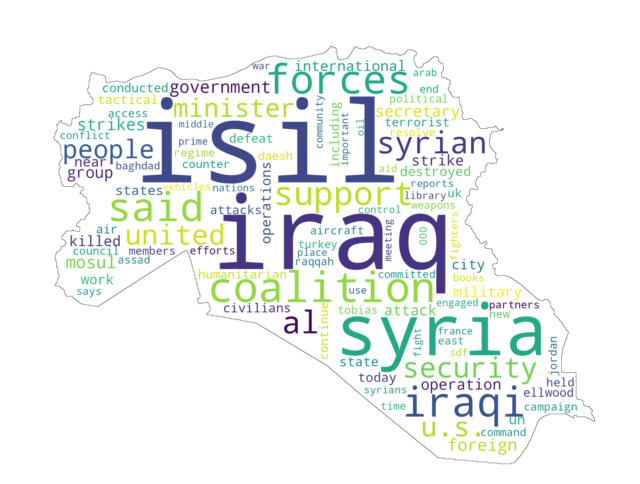

In [ ]:
# Create a dictionary from the DataFrame
word_freq_dict = dict(zip(word_df['Word'], word_df['Frequency']))

png_url = "https://i.ibb.co/VTtj887/Iraq8.png"
response = requests.get(png_url)
img = Image.open(io.BytesIO(response.content))
mask_map = np.array(img)

# Generate a word cloud
wordcloud = WordCloud(background_color='white',
                      mask = mask_map,contour_width=1,  # Adjust this value to make the contours visible
                      contour_color='black')
wordcloud.generate_from_frequencies(word_freq_dict)


# Display the word cloud using Matplotlib
fig = plt.figure(figsize=(8,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

#### Bubble Chart

For the Bubble Chart we considered only the 30 words with the highest frequency in order to make it neat.

In [ ]:
import plotly.express as px

In [ ]:
# Get the top 30 words from 'word_df'
top_30_words_df = word_df.head(30)

# Random position of the words
top_30_words_df_1 = top_30_words_df.sample(frac=1,random_state=30).reset_index(drop=True)

# Create the bubble chart
fig = px.scatter(top_30_words_df_1, x='Word', y='Frequency', size='Frequency', title='Top 30 Words Bubble Chart')

# Customize the appearance of the chart
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))

# Set the axis labels
fig.update_xaxes(title_text='Word')
fig.update_yaxes(title_text='Frequency')

# Show the chart
fig.show()

### LDA

Despite that our document has a clear general topic which is the conflict in Syria and Iraq, we wanted to analyze if there were any underlying topics by using the LDA (Latent Dirichlet Allocation) algorithm used for topic modeling.



In [ ]:
!pip install --no-deps pyLDAvis
!pip install --no-deps funcy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.5 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
all_raw = train_raw + test_raw

sentences = [' '.join(words) for words in all_raw]

sentences = pd.DataFrame(sentences, columns=['Sentences'])

sentences['Sentences']

0      Operation Steel Curtain ( Arabic : Al Hejab El...
1      The hospital has facilities for MRI and CT sca...
2      The operation was important in that it was the...
3      This was my first visit to Uzbekistan and an i...
4      The group was founded by Sheikh Abu Omar al - ...
                             ...                        
958    The head of the country ' s counter - terroris...
959    . Near Rawah , one strike engaged an ISIL tact...
960    The SDF , made up in part by local Arabs and i...
961    The regime and those who back it must immediat...
962    Defeating ISIL will take time and patience but...
Name: Sentences, Length: 963, dtype: object

First we need to create a vocabulary of words from the provided text data while excluding terms that are either too common or too rare. Additionally, we remove common English stopwords. We set the maximum treshold 0.99 and the minimum threshold 0.01 because we tried with different thresholds and the results were not consistent.

Then we need to assign to each token a unique integer and create a Document-Term matrix with all of unique integer.

In [ ]:
#convert a collection of text documents to a matrix of token counts.
cv = CountVectorizer(max_df=0.99, min_df=0.01, stop_words='english')

dtm = cv.fit_transform(sentences['Sentences'])

#dtm represents the frequency of words in the sentences.
dtm

<963x216 sparse matrix of type '<class 'numpy.int64'>'
	with 4467 stored elements in Compressed Sparse Row format>

After some trial and error tests we found that the algorithm gave the most reasonable results when working with 5 topics.

In [ ]:
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

Now we want to print the 15 most representative words for each topic so we can understand the underlying topics.

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['attacks', 'iraq', 'attack', 'terrorist', 'political', 'iraqi', 'today', 'said', 'state', 'killed', 'foreign', 'secretary', 'syria', 'syrian', 'al']


THE TOP 15 WORDS FOR TOPIC #2
['states', 'group', 'said', 'air', 'conducted', 'strikes', 'operations', 'security', 'military', 'united', 'support', 'iraqi', 'forces', 'coalition', 'iraq']


THE TOP 15 WORDS FOR TOPIC #3
['daesh', 'reports', 'oil', 'weapons', 'council', 'access', 'regime', 'defeat', 'international', 'humanitarian', 'security', 'government', 'syria', 'iraq', 'isil']


THE TOP 15 WORDS FOR TOPIC #4
['fighters', 'place', 'karim', 'long', 'coalition', 'syrians', 'just', 'says', 'library', 'books', 'support', '000', 'work', 'uk', 'people']


THE TOP 15 WORDS FOR TOPIC #5
['east', 'forces', 'aircraft', 'city', 'tobias', 'held', 'tactical', 'minister', 'ellwood', 'destroyed', 'said', 'strike', 'near', 'operation', 'isil']




Based on the most representative words for each topic we came up with these underlying topics:

**Topic #1**: political terrorist attack

**Topic #2:**  military coalition operations

**Topic #3:** international humanitarian support

**Topic #4:** uk support

**Topic #5:** strategic tactical operations


Then we attached to the each sentence of our dataframe the topic in which they belong.

In [ ]:
topic_results = LDA.transform(dtm)
sentences['Topic'] = topic_results.argmax(axis=1)
sentences.head()

,Sentences,Topic
0,Operation Steel Curtain ( Arabic : Al Hejab El...,1
1,The hospital has facilities for MRI and CT sca...,3
2,The operation was important in that it was the...,0
3,This was my first visit to Uzbekistan and an i...,3
4,The group was founded by Sheikh Abu Omar al - ...,0


In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

In [ ]:
#Run twice
import warnings

# Suppress DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

To complete our analysis in topic modelling we created a interactive plot, using the pyLDAvis package, for a better understanding of the underlying topics.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(LDA, dtm, cv)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.079132  0.229038       1        1  23.299098
2      0.081630  0.041160       2        1  21.930840
1      0.004048 -0.014628       3        1  21.021507
4     -0.304198 -0.032009       4        1  18.742006
3      0.139388 -0.223561       5        1  15.006550, topic_info=           Term        Freq       Total Category  logprob  loglift
147      people   47.000000   47.000000  Default  30.0000  30.0000
80       forces   76.000000   76.000000  Default  29.0000  29.0000
42    coalition   83.000000   83.000000  Default  28.0000  28.0000
12           al   60.000000   60.000000  Default  27.0000  27.0000
106        isil  159.000000  159.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
43      command    9.688823   19.952278   Topic5  -4.2870   1.1743
174     support   18.575521   70.132144   Topic5  -3.6362   0.5681
42    coalition   14.403426   83.261945   Topic5  -3.8905   0.1422
88   government   11.505438   47.455146   Topic5  -4.1152   0.4797
53      counter    9.177484   27.643194   Topic5  -4.3412   0.7941

[233 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         5  0.968829    000
2         2  0.696405     15
2         4  0.261152     15
3         4  0.302425   2016
3         5  0.680456   2016
...     ...       ...    ...
213       2  0.814023   year
213       3  0.058144   year
213       4  0.058144   year
214       5  0.972423  years
215       5  0.972438  young

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

From this graph we can see how the 4th topic is the most different from the others, while the 2nd and the 3rd are similar and for each topic there are between 15% and 20% of token usage.

# BiLSTM Model to clasify the data

In [ ]:
import urllib
import sklearn
import logging
import random

from io import StringIO
from seqeval.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

To address our named entity recognition task, we constructed a Bidirectional Long Short-Term Memory (BiLSTM) model with the Keras framework. This kind of architecture is very useful for our objective as BiLSTM models has the capability to capture contextual information from both preceding and succeeding tokens within a sequence.

This bidirectional approach increases the model's ability to understand the context surrounding each entity, thereby improving the overall accuracy and effectiveness of the named entity recognition process.

### Creating a validation set and adjusting the data for the model

As a validation set was not initially available, we divided our training set into two distinct subsets.

85% of the data was kept as the training set, while the remaining 15% was designated as the newly created validation set. This strategic split enables us to assess the model's performance on an independent dataset, enhancing the reliability of our training and validation processes.

In [ ]:
# Calculate the number of indices to select (20% of the length of the original list)
num_indices_to_select = int(0.15 * len(train_raw))

# Use random.sample to select random indices without replacement
random.seed(320)
validation_indices = random.sample(range(len(train_raw)), num_indices_to_select)

In [ ]:
validation_raw = [train_raw[i] for i in validation_indices]
validation_NER = [train_NER[i] for i in validation_indices]

train_raw = [train_raw[i] for i in range(len(train_raw)) if i not in validation_indices]
train_NER = [train_NER[i] for i in range(len(train_NER)) if i not in validation_indices]

print("Length of validation set:", len(validation_raw))
print("Length of validation NER set:", len(validation_NER))
print("Length of updated training set:", len(train_raw))
print("Length of updated training NER set:", len(train_NER))

Length of validation set: 114
Length of validation NER set: 114
Length of updated training set: 650
Length of updated training NER set: 650


Now we want to prepare the data for our named entity recognition task by tokenizing the text and assigning an integer ID to each token.

We also encode the labels into integers by enumerating them and created 2 dictionares to associate each ID (integer) to it's tag and viceversa.

In [ ]:
# integer encode sequences of words
tokenizer = Tokenizer()    #lowers tokens
tokenizer.fit_on_texts(train_raw + test_raw + validation_raw)

train_seqs = tokenizer.texts_to_sequences(train_raw)
validation_seqs = tokenizer.texts_to_sequences(validation_raw)
test_seqs = tokenizer.texts_to_sequences(test_raw)

#Dictionary with the tags and it's corresponding id
tag_2_id = { tag: id for id, tag in enumerate(labels) }
#Dictionary with the id's and it's corresponding tag
id_2_tag = { id: tag for tag, id in tag_2_id.items() }

#creates a list of tuples that contain the id of each tag for each phrase
NER_train_seqs = [[tag_2_id[tag] for tag in sentence] for sentence in train_NER]
NER_validation_seqs = [[tag_2_id[tag] for tag in sentence] for sentence in validation_NER]
NER_test_seqs  = [[tag_2_id[tag] for tag in sentence] for sentence in test_NER ]

In [ ]:
tag_2_id

{'I-DocumentReference': 0,
 'B-Temporal': 1,
 'I-Quantity': 2,
 'O': 3,
 'I-Temporal': 4,
 'I-Location': 5,
 'B-Organisation': 6,
 'I-Nationality': 7,
 'B-Nationality': 8,
 'I-Organisation': 9,
 'B-MilitaryPlatform': 10,
 'B-Weapon': 11,
 'I-Weapon': 12,
 'I-MilitaryPlatform': 13,
 'B-Quantity': 14,
 'B-Location': 15,
 'B-Money': 16,
 'B-Person': 17,
 'I-Money': 18,
 'I-Person': 19,
 'B-DocumentReference': 20}

In [ ]:
print(train_raw[0])
print(train_seqs[0])
for i in train_seqs[0]:
    print(f'{i} : {tokenizer.index_word[i]}')

['Operation', 'Steel', 'Curtain', '(', 'Arabic', ':', 'Al', 'Hejab', 'Elfulathi', ')', 'was', 'a', 'military', 'operation', 'executed', 'by', 'coalition', 'forces', 'in', 'early', 'November', '2005', 'to', 'reduce', 'the', 'flow', 'of', 'foreign', 'insurgents', 'crossing', 'the', 'border', 'and', 'joining', 'the', 'Iraqi', 'insurgency', '.']
[72, 650, 651, 67, 242, 40, 45, 1946, 1947, 68, 28, 8, 79, 72, 1948, 21, 32, 35, 7, 551, 289, 1312, 6, 971, 1, 972, 5, 59, 973, 763, 1, 552, 4, 1313, 1, 36, 974, 3]
72 : operation
650 : steel
651 : curtain
67 : (
242 : arabic
40 : :
45 : al
1946 : hejab
1947 : elfulathi
68 : )
28 : was
8 : a
79 : military
72 : operation
1948 : executed
21 : by
32 : coalition
35 : forces
7 : in
551 : early
289 : november
1312 : 2005
6 : to
971 : reduce
1 : the
972 : flow
5 : of
59 : foreign
973 : insurgents
763 : crossing
1 : the
552 : border
4 : and
1313 : joining
1 : the
36 : iraqi
974 : insurgency
3 : .


We now see the size of or vocabulary and also the distribution of the sentences length:

In [ ]:
#Size of the vocabulary
vocab_size = len(tokenizer.word_counts)
print(vocab_size)

3925


In [ ]:
seq_lens = np.array([len(s) for s in train_seqs])
longest_sequence = seq_lens.max()
print("Length of the longest sequence:",longest_sequence)

print([(str(p) + '%', np.percentile(seq_lens, p)) for p in range(75,101, 5)])

Length of the longest sequence: 154
[('75%', 34.0), ('80%', 36.0), ('85%', 39.0), ('90%', 43.0), ('95%', 49.0), ('100%', 154.0)]


To ensure consistent sequence lengths for our NLP task, we applied padding to token sequences for training, validation, and test sets, fixing their length at 40 words to cover over 85% of the data.

Simultaneously, we created vectors to represent class labels that will be defined as our target variable.

In [ ]:
#Padding
max_seq_len = 40
X_train = pad_sequences(train_seqs, maxlen=max_seq_len, padding='post', truncating='post')
X_validation = pad_sequences(validation_seqs, maxlen=max_seq_len, padding='post', truncating='post')
X_test = pad_sequences(test_seqs, maxlen=max_seq_len, padding='post', truncating='post')

Y_train = pad_sequences(NER_train_seqs, maxlen=max_seq_len, value=tag_2_id['O'], padding='post', truncating='post')
Y_validation = pad_sequences(NER_validation_seqs, maxlen=max_seq_len, value=tag_2_id['O'], padding='post', truncating='post')
Y_test = pad_sequences(NER_test_seqs, maxlen=max_seq_len, value=tag_2_id['O'], padding='post', truncating='post')

#Categorical list
Y_train = to_categorical(Y_train, num_classes=len(labels), dtype='int32')
Y_validation = to_categorical(Y_validation, num_classes=len(labels), dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(labels), dtype='int32')

In [ ]:
print(X_train[0])
print(Y_train[0])

[  72  650  651   67  242   40   45 1946 1947   68   28    8   79   72
 1948   21   32   35    7  551  289 1312    6  971    1  972    5   59
  973  763    1  552    4 1313    1   36  974    3    0    0]
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0

We assign the index 0 to the padding character and transform the data into numpy arrays so we are able to work with it for the model.

In [ ]:
tokenizer.index_word[0] = '_PAD_'

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_validation = np.array(X_validation)
Y_validation = np.array(Y_validation)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# 650 phrases, 40 words, for Y 21 labels
print(X_train.shape)
print(Y_train.shape)

(650, 40)
(650, 40, 21)


To increase the capacity of our model, we use pretrained embeddings generated using the GloVe method, sourced directly from the Stanford University webpage.

We also defined a custom-built function designed to generate an embedding matrix. This matrix serves as a input to our model when the variable *glove_bool* is set to True.

In [ ]:
glove_BOOL=True

In [ ]:
#create the embedding matrix using pretrained Glove embeddings
def load_glove_embedding_matrix(path, word_index, embed_dim):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# Download GloVe file
!wget https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded file
!unzip glove.6B.zip

# Move the required file to the current directory
!mv glove.6B.100d.txt /content

--2023-11-28 16:16:13--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-28 16:16:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 43s  

2023-11-28 16:18:58 (5.05 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
#Run only once
os.remove('/content/glove.6B.300d.txt')
os.remove('/content/glove.6B.200d.txt')
os.remove('/content/glove.6B.50d.txt')
os.remove('/content/glove.6B.zip')

In [ ]:
glove_emb_matrix=None
glove_embedding_path = os.path.join('/content/', 'glove.6B.100d.txt')
embedding_dim = 100
glove_emb_matrix = load_glove_embedding_matrix(glove_embedding_path, tokenizer.word_index, embedding_dim)

Found 400000 word vectors.


In [ ]:
def check_for_missing_words(embedding_matrix):
    # Find the indices of zero rows
    zero_rows = np.all(embedding_matrix == 0, axis=1)

    # Extract the words that have zero rows
    missing_words = [word for word, is_zero in zip(tokenizer.word_index.keys(), zero_rows) if is_zero]

    return missing_words

# Check for missing words in the embedding matrix
missing_words = check_for_missing_words(glove_emb_matrix)

print("Words not found in pre-trained embeddings:", missing_words)
print("Total words missing:", len(missing_words))

Words not found in pre-trained embeddings: ['the', '-', 's', 'attacks', '000', 'since', 'under', 'e', 'forward', 'each', 'kerry', 'almost', 'language', 'contribution', 'markets', 'square', 'entrance', 'myself', 'sale', 'ensuring', 'feel', 'barbarity', 'record', 'ambassador', 'mistura', 'ā', 'minutes', 'born', 'thank', '167988', 'bloodshed', 'hemr', 'î', '269635', 'kirkuk', 'executed', 'latakia', 'posture', 'nationwide', 'bbcnewsmagazine', 'facebook', 'eurobird', 'clan', 'credibility', 'sarmin', 'talamenes', 'cruel', 'responds', 'pittsburgh', 'facilitating', 'ü', 'lu', 'reaffirms', 'ū', 'zumar', 'broken', 'uscentcom', 'vertical', 'chronicled', 'clarify', 'marketplace', 'forefront', 'shortly', 'distance', 'neighbourhood', 'obstruction', 'stratotanker', 'alahmar', '20s', 'license', 'declared', 'uncontested', 'conductor', 'premiere', "'s", 'transliterated', 'kurmanji', 'glance', 'q', 'warfighter', 'mutual', 'fault', 'middleman', 'custom', 'coode', 'unified', 'southwest', 'monetary', 'kasas

#### Constructing the model

The chosen architecture for named entity recognition (NER) and text classification employs a Bidirectional Long Short-Term Memory
We decided to move with an architecture employing a
BiLSTM model with bidirectional processing, embedding layer, dropout regularization, and dense layers.

The bidirectional LSTM layers capture contextual information for understanding the sequence of words. The embedding layer provides semantic representation, and in our case we will use pre-trained GloVe embeddings to initialize the weights hoping that this will improve the performance.
Dropout layers prevent overfitting, and dense layers allow high-level feature extraction.

A final dense layer using softmax activation and incorporating categorical cross-entropy loss, the Adam optimizer, and the metrics of interest will be the accuracy, precision, and recall.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def BiLSTM_model(vocabulary_size, seq_len, n_classes, hidden_cells=146,
                  embed_dim=100, drop=0.4, glove_bool=False, glove_matrix=None):

    model = Sequential()
    if glove_bool: #embedding layer to initialize the weights
        model.add(Embedding(vocabulary_size, embed_dim,
                            weights=[glove_matrix], input_length=seq_len,
                            mask_zero=True, trainable=True))
    else:
        model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len,
                            mask_zero=True))
    model.add(Dropout(drop)) #Drop-out layer to avoid overfitting
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True,    #return sequence is to ensure
                                 dropout=drop, recurrent_dropout=drop))) #the output of the layer has
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True,    #the same sequence length of the
                                 dropout=drop, recurrent_dropout=drop))) #output
    model.add(Dense(hidden_cells))
    model.add(Dropout(drop))
    model.add(Dense(n_classes, activation='softmax')) #softmax because of multi-class classification
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    model.summary()
    return model

In [ ]:
BiLSTM_model = BiLSTM_model(vocab_size+1,max_seq_len,len(labels),glove_bool=glove_BOOL,
                            glove_matrix=glove_emb_matrix)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           392600    
                                                                 
 dropout (Dropout)           (None, 40, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 40, 292)           288496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40, 292)           512752    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 40, 146)           42778     
                                                                 
 dropout_1 (Dropout)         (None, 40, 146)           0

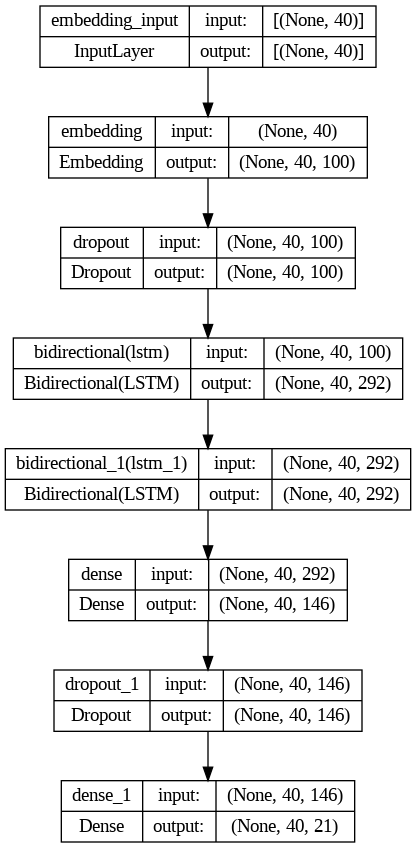

In [ ]:
plot_model(BiLSTM_model,show_shapes=True, show_layer_names=True)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

We also added some callbacks like **ModelCheckpoint** to save only the model weights that lead to the best performance on the validation set trying to avoid overfitting on the training data.

And an **EarlyStopping** that prevents overfitting by interrupting training when performance on the validation set stalls and saves computation time by avoiding unnecessary epochs when the model is no longer improving.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
BiLSTM_model.save('bilstm_model.h5')
model_path = os.path.join('/content/', 'bilstm_model.h5')
checkpoint = ModelCheckpoint(
    model_path,
    save_weights_only=True,
    save_best_only=True,
)

early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3,
                                        verbose=1, mode="auto", restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



#### Training the model

After fine-tuning the model, we determined that the best results were obtained using a batch size of 15 and training for 15 epochs. This configuration takes approximately just over 9 minutes to complete the training process, without any interruptions from the early stopping callback.

In [ ]:
import tensorflow as tf

In [ ]:
%%time
np.random.seed(320)
random.seed(320)
tf.random.set_seed(320)
batch_size = 15
history = BiLSTM_model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          epochs=15,
          verbose=2,
          callbacks=[checkpoint,early_stopping_callback],
          validation_data=(X_validation, Y_validation)#,
          #class_weight=class_weight_dict
         )

Epoch 1/15
44/44 - 94s - loss: 1.4732 - accuracy: 0.6725 - precision: 0.7161 - recall: 0.5210 - val_loss: 1.1912 - val_accuracy: 0.6866 - val_precision: 0.7660 - val_recall: 0.5946 - 94s/epoch - 2s/step
Epoch 2/15
44/44 - 58s - loss: 1.1651 - accuracy: 0.6927 - precision: 0.7661 - recall: 0.6023 - val_loss: 0.9891 - val_accuracy: 0.7202 - val_precision: 0.7967 - val_recall: 0.6523 - 58s/epoch - 1s/step
Epoch 3/15
44/44 - 48s - loss: 1.0065 - accuracy: 0.7184 - precision: 0.7991 - recall: 0.6361 - val_loss: 0.8303 - val_accuracy: 0.7437 - val_precision: 0.8416 - val_recall: 0.6635 - 48s/epoch - 1s/step
Epoch 4/15
44/44 - 51s - loss: 0.8813 - accuracy: 0.7380 - precision: 0.8164 - recall: 0.6614 - val_loss: 0.6968 - val_accuracy: 0.7787 - val_precision: 0.8544 - val_recall: 0.7119 - 51s/epoch - 1s/step
Epoch 5/15
44/44 - 39s - loss: 0.8129 - accuracy: 0.7527 - precision: 0.8250 - recall: 0.6826 - val_loss: 0.6886 - val_accuracy: 0.7812 - val_precision: 0.8581 - val_recall: 0.7245 - 39s/e

##### Summarizing results

The following graph illustrates the progressive improvement of accuracy with each epoch in the training set. For the validation set also demonstrates an ascending trend in accuracy, despite occasional decreases in certain epochs. This suggests that on the whole, the model effectively achieves a good level of fitting for new data.

In [ ]:
import matplotlib.pyplot as plt

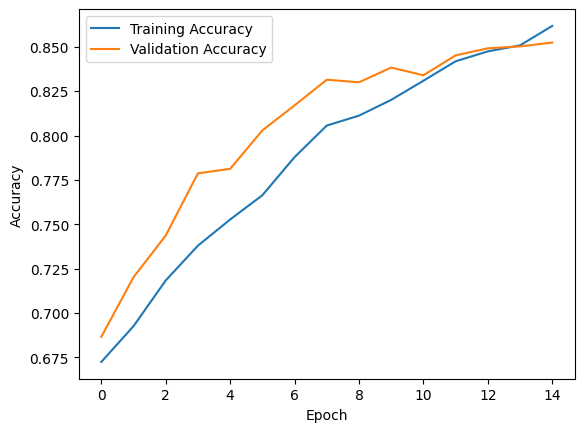

In [ ]:
# Plotting training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In order to be able to see the actual precision and recall of our model we first need to remove the padding tokens from our target variable and our prediction and, also to retrieve the actual label of the prediction using the id that is the position of the maximum argument of each tuple.

In [ ]:
def remove_seq_padding(X, y_true, y_pred, pad=0):
    #Remove padding predictions from list of sequences
    new_true = []
    new_pred = []
    for sent_idx in range(len(X)): #to iterate over each sentence of X
        true_sent = []
        pred_sent = []
        for tok_idx in range(len(X[sent_idx])): #to iterate over each token for each sentence
            if X[sent_idx][tok_idx] != pad:
                true_sent.append(y_true[sent_idx][tok_idx])
                pred_sent.append(y_pred[sent_idx][tok_idx])
        new_true.append(true_sent)
        new_pred.append(pred_sent)
    return np.array(new_true,dtype="object"), np.array(new_pred,dtype="object")

def from_encode_to_literal_labels(y_true, y_pred, idx2tag):
    #Transform sequences of encoded labels in sequences of string labels
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)): #to iterate over each sentence of Y
        let_sent_true = []
        let_sent_pred = []
        for token_idx in range(len(y_true[sent_idx])): #to iterate over each token for each sentence
            let_sent_true.append(idx2tag[y_true[sent_idx][token_idx]])
            let_sent_pred.append(idx2tag[y_pred[sent_idx][token_idx]])
        let_y_true.append(let_sent_true)
        let_y_pred.append(let_sent_pred)

    return let_y_true, let_y_pred

Our model seems to have a moderate precission, which measures the accuracy of the positive predictions, indicating that we might have a high number of false positives.

For the recall the results across the sets improve significantly which suggest that that our model effectively minimizes the occurrence of false negatives.

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test), ('Validation Set', X_validation, Y_validation)]

for title, X, Y in datasets:
    Y_pred = BiLSTM_model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred, id_2_tag)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

44/44 [==============================] - 5s 93ms/step
Training Set


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                   precision    recall  f1-score   support

DocumentReference      0.189     0.263     0.220        38
         Location      0.633     0.728     0.677       500
 MilitaryPlatform      0.385     0.405     0.395        37
            Money      0.353     0.400     0.375        15
      Nationality      0.000     0.000     0.000        25
     Organisation      0.614     0.703     0.655       917
           Person      0.737     0.870     0.798       338
         Quantity      0.659     0.680     0.669       122
         Temporal      0.594     0.607     0.601       140
           Weapon      0.400     0.411     0.405        73

        micro avg      0.618     0.695     0.654      2205
        macro avg      0.456     0.507     0.480      2205
     weighted avg      0.611     0.695     0.650      2205



14/14 [==============================] - 1s 63ms/step
Test Set
                   precision    recall  f1-score   support

DocumentReference      0.071     0.125     0.0

In [ ]:
from sklearn.metrics import accuracy_score

Despite not having the best results in terms of precission our model manages to get very decent levels of accuracy across all sets, with more than 80% of accuracy for the train, validation and test set.

In [ ]:
accuracies = []

for title, X, Y in datasets:
    Y_pred = BiLSTM_model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred, id_2_tag)

    # Convert lists of 2D arrays to a single 2D array
    let_y_true_2d = np.concatenate(let_y_true, axis=0)
    let_y_pred_2d = np.concatenate(let_y_pred, axis=0)

    # Flatten the 2D arrays to 1D
    let_y_true_flat = np.ravel(let_y_true_2d)
    let_y_pred_flat = np.ravel(let_y_pred_2d)

    accuracy = accuracy_score(let_y_true_flat, let_y_pred_flat)
    accuracies.append(accuracy)
    print(f'{title} Accuracy: {accuracy:.3f}')

44/44 [==============================] - 6s 132ms/step
Training Set Accuracy: 0.894
14/14 [==============================] - 3s 245ms/step
Test Set Accuracy: 0.838
8/8 [==============================] - 1s 133ms/step
Validation Set Accuracy: 0.845


# BERT Model

The 'simpletransformers'  package is built on top of the 'transformer' library, it simplyfies the process by making it more user friendly and limiting the customization and control.


In [ ]:
!pip install simpletransformers

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

The test and train dataset have been concatenated together to apply easily the sentence counter and then the label encoder in order to prepare the data to be used in the Model.



In [ ]:
# Read the data from the URL into Pandas DataFrames
data_test_model = pd.read_csv(url_raw_test, sep='\t', header=None, names=['Token', 'Tag'], quoting=3)
data_train_model  = pd.read_csv(url_raw_train, sep='\t', header=None, names=['Token', 'Tag'], quoting=3)

# Concatenate the two DataFrames
combined_data = pd.concat([data_train_model, data_test_model], ignore_index=True)

# Initialize the 'Sentence #' column
combined_data['Sentence #'] = None

# Counter to keep track of sentence number
sentence_counter = 1

# Iterate through the rows
for i in range(len(combined_data)):
    # Update the 'Sentence #' column
    combined_data.at[i, 'Sentence #'] = f'Sentence: {sentence_counter}'

    # Check if the token is "."
    if combined_data.at[i, 'Token'] == ".":
        sentence_counter += 1

# Print the updated DataFrame
print(combined_data)

           Token         Tag     Sentence #
0      Operation           O    Sentence: 1
1          Steel           O    Sentence: 1
2        Curtain           O    Sentence: 1
3              (           O    Sentence: 1
4         Arabic           O    Sentence: 1
...          ...         ...            ...
25283       time  B-Temporal  Sentence: 977
25284         of  I-Temporal  Sentence: 977
25285        the  I-Temporal  Sentence: 977
25286     attack  I-Temporal  Sentence: 977
25287          .           O  Sentence: 977

[25288 rows x 3 columns]


The 'combined_data' dataset has been splitted again respecting the initial train-test proportion, X contains the features (sentence_id and words) and  Y contains the corresponding labels.

In [ ]:
combined_data['Sentence #'] = LabelEncoder().fit_transform(combined_data['Sentence #'])

combined_data.rename(columns={"Sentence #":"sentence_id","Token":"words", "Tag":"labels"},inplace=True)
combined_data["labels"]=combined_data["labels"].str.upper()

X = combined_data[["sentence_id","words"]]
Y = combined_data["labels"]

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
# Specify the number of rows for training
train_size = 20030

# Extract the first train_size rows for training and reset the index to start from 0
train_data = combined_data.head(train_size).reset_index(drop=True)

# Extract the remaining rows for testing and reset the index to start from 0
test_data = combined_data.tail(len(combined_data) - train_size).reset_index(drop=True)

In [ ]:
x_train = train_data[["sentence_id", "words"]]
y_train = train_data["labels"]

x_test = test_data[["sentence_id", "words"]]
y_test = test_data["labels"]

train = pd.DataFrame({"sentence_id": x_train["sentence_id"], "words": x_train["words"], "labels": y_train})
test = pd.DataFrame({"sentence_id": x_test["sentence_id"], "words": x_test["words"], "labels": y_test})

In [ ]:
from simpletransformers.ner import NERModel, NERArgs

'args' are used to initialize the model, setting epochs, learning rate and batch size, the seed has been set manually to have reproducible results.
A small batch size (15) has been chosen for memory efficiency during training which is beneficial for limited GPU capacity, the number of epochs, such as the batch size and the learning rate, have been set after several experiments to optimize the trade-off between memory efficiency, precision and computational time.

In [ ]:
label = combined_data["labels"].unique().tolist()

args=NERArgs()
args.num_train_epochs = 15
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.t rain_batch_size = 15
args.eval_batch_size = 15
args.manual_seed = 246

'NERModel' is a function from the simpletransformer package specific for NER, it provides a simplified and user-friendly interface for Name Entity Recognition tasks, reducing complexity such as tokenization, training loops and evaluation.

In [ ]:
BERT_model = NERModel('bert','bert-base-cased', labels = label, args = args)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
BERT_model.train_model(train, eval_data=test, acc=accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Running Epoch 1 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/52 [00:00<?, ?it/s]

(780, 0.16579757303063675)

In [ ]:
result_test, model_outputs_test, pred_list_test=BERT_model.eval_model(test)
result_train, model_outputs_train, pred_list_train=BERT_model.eval_model(train)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
result_train

{'eval_loss': 0.00841967019648739,
 'precision': 0.987604812249362,
 'recall': 0.9894083272461651,
 'f1_score': 0.9885057471264369}

In [ ]:
result_test

{'eval_loss': 0.695407047867775,
 'precision': 0.6743589743589744,
 'recall': 0.7690058479532164,
 'f1_score': 0.7185792349726776}

In [ ]:
from itertools import chain
flat_pred_train = list(chain.from_iterable(pred_list_train))
flat_pred_test = list(chain.from_iterable(pred_list_test))

In [ ]:
accuracy_train = accuracy_score(y_true=y_train,y_pred=flat_pred_train)
accuracy_train

0.48412381427858214

In [ ]:
accuracy_test = accuracy_score(y_true=y_test,y_pred=flat_pred_test)
accuracy_test

0.892164321034614

In [ ]:
BERT_model.save_model(output_dir='/content/' )

- The evaluation loss is a measure of how weel the model is performing on the validation set. A lower value indicates better performance. In this case, the evaluation loss is 0.6954 on the test set and 0.0084 on the train one, which suggests that the model is making accurate predictions.
- Precision is the ratio of true positive predictions to the total number of predicted positives. It measures the accuracy of positive predictions. The precision of approximately 67.43% and 98.94% on the test and train dataset respectively indicate that about 67.43% and 98.94% of the predicted entities are correct.
- Recall (or sensitivity) is the ratio of true positive predictions to the total number of actual positives. It measures the ability of the model to capture all positive instances. The recall of approximately 76.9% on the test dataset indicates that the model is capturing about 76.9% of the actual entities, the recall ratio of the train dataset is higer, with 98.94% of entities captured correctly.
- The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The F1 scores of approximately 71.86% on the test dataset and 98.85% on the train dataset indicate a reasonable trade-off between precision and recall.

The model's performance has been evaluated through various metrics on both the test and train datasets. The evaluation loss, which measures how well the model is performing on the validation set, is notably low at 0.6954 for the test set and 0.0084 for the train set. This suggests that the model is making accurate predictions and generalizing well.

In conclusion, the model performs well on both the test and train datasets, demonstrating accuracy in predictions, strong precision, and effective capture of actual positive instances. The balance achieved by the F1 score further reinforces the model's overall robustness in handling positive predictions and actual positive instances.

# Comparing both models

In evaluating the named entity recognition performance of the BiLSTM and BERT models across training, test, and validation sets, we need to consider different factor before providing a definitive conclussion.

The BiLSTM model displays variations in precision, recall, and F1-score among different named entity classes but achieves robust accuracy across sets, with values of 89.4%, 83.8%, and 84.5% on the training, test, and validation sets, respectively.

In contrast, the BERT model demonstrates a low evaluation loss (0.6954 for the test set, 0.0084 for the training set), suggesting accurate predictions and generalization. Precision is notably high on both the test (67.43%) and training sets (98.94%), along with strong recall (76.9% on the test set, 98.94% on the training set). The model achieves an accuracy of 89.2% on the test set.

In conclusion, the BiLSTM model demonstrates nuanced performance across named entity classes, while the BERT model excels in consistently high precision, recall, and F1 scores. The choice between these models falls on the specific requirements of the named entity recognition task, considering the tradeoff between precision and recall.